In [1]:
import pandas as pd
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')
from datetime import datetime, timezone
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [4]:
###compare cg calls with classifier from Elabbady et al., 2024
settime = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
md3 = client.materialize.query_table('aibs_metamodel_celltypes_v661', timestamp = settime)

df = pd.read_csv("./NotebookInputs/cg_cell_type_calls.csv")
print (df.shape)
##find which calls where annototator disagrees to drop
df['duplicated'] = df.duplicated(subset ='post_pt_root_id', keep = False)
df_dup = df.loc[df['duplicated'] == True]
df_dup_group = df_dup.groupby(by = ['post_pt_root_id', 'cell_type']).count().reset_index()

exclude_selfdisagree = df_dup_group.loc[df_dup_group['duplicated'] == 1].reset_index()
exclude_selfdisagree['exclude'] = 1
exclude_id = exclude_selfdisagree[['post_pt_root_id', 'exclude']]
print (exclude_id.shape)

df_toexclude = pd.merge(df, exclude_id, left_on = 'post_pt_root_id', right_on = 'post_pt_root_id', how = 'left')
print (df_toexclude.shape)
print (df_toexclude.head(40))

df2 = df_toexclude.loc[df_toexclude['exclude'] != 1]
print (df2.shape)
df3 = df2.drop_duplicates(subset ='post_pt_root_id')
print (df3.shape)
df_comp = pd.merge(df3, md3, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')
print (df_comp.shape)
df_comp = df_comp.drop_duplicates(subset ='post_pt_root_id')
print (df_comp.shape)

# ##renaming cell types and removing non neuronal cells
df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('1P','23P')
df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_IT','5P-IT')
df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_NP','5P-NP')
df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_PT','5P-ET')                   
                   
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('BC','INH')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('MC','INH')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('NGC','INH')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('BPC','INH')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('6P-CT','6P')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('6P-IT','6P')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('OPC','Glia')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('astrocyte','Glia')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('oligo','Glia')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('microglia','Glia')
df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('pericyte','Glia')
df_comp_noglia = df_comp.loc[df_comp['cell_type_y'] != 'Glia']
df_comp_npnoglia = df_comp_noglia.loc[df_comp['cell_type_y'] != '5P-NP']
df_comp_npnoglia = df_comp_npnoglia.loc[df_comp['cell_type_x'] != '5P-NP']

df_comp_sub = df_comp_npnoglia[['cell_type_x','pt_root_id',  'cell_type_y' ]]
df_comp_sub = df_comp_sub.rename(columns={"cell_type_x": "Manual", "cell_type_y": "Predicted"})
# df_pivot = pd.pivot_table(df_comp_sub, index=['Manual'],
#                     columns=['Predicted'], aggfunc="count", fill_value=0)
df_ct = pd.crosstab(df_comp_sub["Manual"], df_comp_sub["Predicted"])
print (df_ct)
df_ct_norm = pd.crosstab(df_comp_sub["Manual"], df_comp_sub["Predicted"], normalize = "index")
print (df_ct_norm)
df_ct_norm = df_ct_norm*100

(2868, 18)
(34, 2)
(2900, 20)
    Unnamed: 0     id_ref                       created_ref valid_ref   size  \
0            0  252841327  2020-11-04 14:33:23.840014+00:00         t   1264   
1            1  252889242  2020-11-04 10:33:52.615201+00:00         t    896   
2            2  234601405  2020-11-04 11:41:10.073096+00:00         t   1576   
3            3  248722118  2020-11-04 13:28:14.430823+00:00         t   5028   
4            4  220312874  2020-11-04 08:51:40.223504+00:00         t   4356   
5            5  183058872  2020-11-04 10:59:18.897750+00:00         t   2908   
6            6  244605791  2020-11-04 07:09:38.829357+00:00         t   2272   
7            7  254666730  2020-11-04 08:43:50.837853+00:00         t    956   
8            8  220954051  2020-11-04 10:01:09.128256+00:00         t   2464   
9            9  280018388  2020-11-04 12:41:19.361092+00:00         t   3036   
10          10  223330668  2020-11-04 11:42:14.809791+00:00         t   3008   
11        

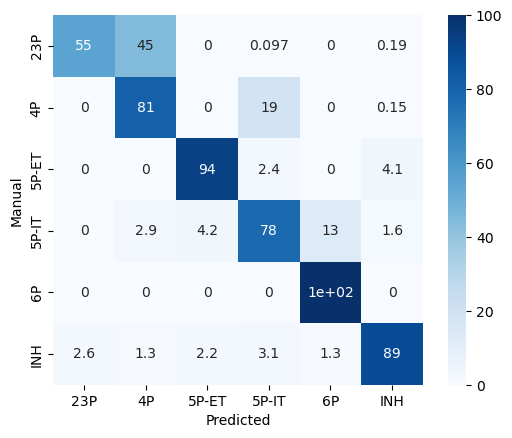

In [5]:
ax = sns.heatmap(df_ct_norm, cmap = "Blues", annot= True, square = True)
# plt.savefig('manual_vs_classifier_aibs_metamodel_celltypes_v661_qdate09192023_normx100_blues_090624.pdf')

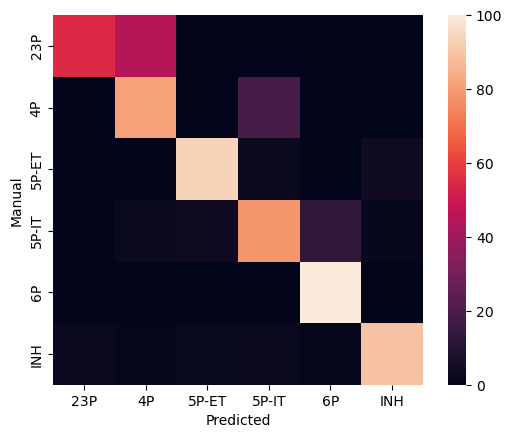

In [6]:
ax = sns.heatmap(df_ct_norm, square = True)
# plt.savefig('manual_vs_classifier_aibs_metamodel_celltypes_v661_qdate09192023_050424.png')